# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


In [3]:
df = pd.read_csv('../Data/TwitterDataset.csv',index_col=0)
df.head()

,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,15/10/16 21:32,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,7.874060e+17,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,09/11/16 5:01,False,False,Photographing the American West since 1980. I ...,536,860,880,False,7.962160e+17,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,17/06/17 5:34,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,8.759500e+17,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human
3,21/07/16 13:32,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,7.561200e+17,en,"Birmingham, AL",NaN,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,False,0.889,1489,human
4,15/01/12 16:32,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,4.647813e+08,en,"England, United Kingdom",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,True,1.339,3138,human


# Prepocessing


## Dropping useless columns

In [4]:
remove = ['location', 'screen_name', 'created_at' , 'profile_image_url', 'profile_background_image_url', 'id', 'description']
df.drop(remove, inplace= True, axis=1)
df.head()

,default_profile,default_profile_image,favourites_count,followers_count,friends_count,geo_enabled,lang,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,False,False,4,1589,4,False,en,11041,False,7.870,1403,bot
1,False,False,536,860,880,False,en,252,False,0.183,1379,human
2,False,False,3307,172,594,True,en,1001,False,0.864,1159,human
3,True,False,8433,517,633,True,en,1324,False,0.889,1489,human
4,False,False,88,753678,116,True,en,4202,True,1.339,3138,human


In [5]:
#Label Encoding language column
df['lang'] = LabelEncoder().fit_transform(df['lang'])
df['account_type'] = LabelEncoder().fit_transform(df['account_type'])
df['account_type'] = df['account_type'].replace({0:1, 1:0})
# 1 - Bot 0 - Human
df.head()

,default_profile,default_profile_image,favourites_count,followers_count,friends_count,geo_enabled,lang,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,False,False,4,1589,4,False,9,11041,False,7.870,1403,1
1,False,False,536,860,880,False,9,252,False,0.183,1379,0
2,False,False,3307,172,594,True,9,1001,False,0.864,1159,0
3,True,False,8433,517,633,True,9,1324,False,0.889,1489,0
4,False,False,88,753678,116,True,9,4202,True,1.339,3138,0


## Splitting twitter df into training and testing

In [6]:
training_data = df.sample(frac=0.67, random_state=25)
testing_data = df.drop(training_data.index)
print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 25083
No. of testing examples: 12355


## Predefining some functions

In [7]:
def load_train_data():
    X_train = training_data.drop(columns='account_type')
    y_train = training_data['account_type']
    
    return X_train, y_train

def load_test_data():
    X_test = testing_data.drop(columns='account_type')
    y_test = testing_data['account_type']
    
    return X_test, y_test

In [8]:
def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)
    train_scores = scores['train_score']
    val_scores = scores['test_score']
    
    train_mean = np.mean(train_scores)
    val_mean = np.mean(val_scores)
    
    return train_mean, val_mean

In [9]:
def print_grid_search_result(grid_search):    
    print(grid_search.best_params_)
    
    best_train = grid_search.cv_results_["mean_train_score"][grid_search.best_index_]
    print("best mean_train_score: {:.3f}".format(best_train))
        
    best_test = grid_search.cv_results_["mean_test_score"][grid_search.best_index_]
    print("best mean_test_score: {:.3f}".format(best_test))

# Cross Validation
We cross validate our data across 5 different classification models, and test for accuracy. 

In [10]:

model_list = [LogisticRegression(max_iter=600),
              SVC(), 
              GaussianNB(),
              RandomForestClassifier(random_state=55),
              GradientBoostingClassifier(random_state=56)]

train_scores = []
val_scores = []

X_train, y_train = load_train_data()
for model in model_list:
    train, val = get_classifier_cv_score(model, X_train, y_train,'average_precision')
    train_scores.append(train)
    val_scores.append(val)
    
models_score = sorted(list(zip(val_scores, train_scores, model_list)), reverse=True)

print("-------------------------------------")
for val, train, model in models_score:
    print("Model: {} ".format(model.__class__.__name__))

    print("train_score: {:.3f}".format(train)) 

    print("validation_score: {:.3f}".format(val)) 

    print("-------------------------------------")

-------------------------------------
Model: RandomForestClassifier 
train_score: 1.000
validation_score: 0.901
-------------------------------------
Model: GradientBoostingClassifier 
train_score: 0.891
validation_score: 0.877
-------------------------------------
Model: LogisticRegression 
train_score: 0.580
validation_score: 0.578
-------------------------------------
Model: SVC 
train_score: 0.557
validation_score: 0.552
-------------------------------------
Model: GaussianNB 
train_score: 0.492
validation_score: 0.492
-------------------------------------


Above we can see our scores for each model. The 2 best models are:
1. Random Forest
2. Gradient Boosting

# Hyperparameter Tuning

Now, we can try to tune the parameters of two of our best models to check which yeilds the best results.

## Tuning the Random Forest model
We tune the model across two parameters: 
1. Number of Estimators
2. Maximum Depth


In [11]:
model = RandomForestClassifier(random_state=55)
parameters = {'n_estimators': [300, 500, 700, 1000],
              'max_depth': [7, 9, 11, 13]}
grid1 = GridSearchCV(model, parameters, cv=7, scoring='average_precision',return_train_score=True)

In [12]:
grid1.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=55),
             param_grid={'max_depth': [7, 9, 11, 13],
                         'n_estimators': [300, 500, 700, 1000]},
             return_train_score=True, scoring='average_precision')

In [13]:
print_grid_search_result(grid1)

{'max_depth': 13, 'n_estimators': 700}
best mean_train_score: 0.980
best mean_test_score: 0.903


Our best result comes with a Maximum Depth of 13, and Number of estimators = 700.
We can notice a pattern, where in, increasing our Maximum depth is improving our accuracy. So we now try increasing the depth once again to test whether it would improve our result or not. 

In [14]:
new_params = {
    'n_estimators':[700],
    'max_depth':[13, 15, 17, 19]
}
model = RandomForestClassifier(random_state=55)
newGrid = GridSearchCV(model, new_params, cv=7, scoring='average_precision',return_train_score=True)

In [15]:
newGrid.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=55),
             param_grid={'max_depth': [13, 15, 17, 19], 'n_estimators': [700]},
             return_train_score=True, scoring='average_precision')

In [16]:
print_grid_search_result(newGrid)

{'max_depth': 19, 'n_estimators': 700}
best mean_train_score: 1.000
best mean_test_score: 0.906


Increasing the depth made a slight difference to our accuracy, we see an increased accuracy when our depth is 19
1. Number of Estimators = 700
2. Maximum Depth = 19

Once again, we can try increasing our depth to check for an increase in accuracy

In [17]:
new_params = {
    'n_estimators':[700],
    'max_depth':[20, 25, 30]
}
model = RandomForestClassifier(random_state=55)
newGrid = GridSearchCV(model, new_params, cv=7, scoring='average_precision',return_train_score=True)

In [18]:
newGrid.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=55),
             param_grid={'max_depth': [20, 25, 30], 'n_estimators': [700]},
             return_train_score=True, scoring='average_precision')

In [19]:
print_grid_search_result(newGrid)

{'max_depth': 20, 'n_estimators': 700}
best mean_train_score: 1.000
best mean_test_score: 0.906


Law of diminishing returns - Accuracy does not improve anymore, so we keep depth at 20.

## Tuning the Gradient Boosting Classifier
Once again, we tune the model for 2 specific parameters:
1. Number of Estimators
2. Learning Rate

In [20]:
model = GradientBoostingClassifier(max_depth=5, random_state=56)

parameters = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0]}

#if run on own computer
#grid2 = GridSearchCV(model, parameters, cv=7, scoring='average_precision', n_jobs=num_cpu, return_train_score=True)
grid2 = GridSearchCV(model, parameters, cv=7, scoring='average_precision', return_train_score=True)

In [21]:
grid2.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=GradientBoostingClassifier(max_depth=5, random_state=56),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='average_precision')

In [22]:
print_grid_search_result(grid2)

{'learning_rate': 0.1, 'n_estimators': 200}
best mean_train_score: 0.952
best mean_test_score: 0.900


Once again we notice, that on increasing the number of estimators, we are getting an increased accuracy.
So we can try increasing our estimators to check whether we get better results or not.

In [23]:
new_params2 = {
'n_estimators': [200, 250, 300, 350],
'learning_rate': [0.1]
}
model = GradientBoostingClassifier(max_depth=5, random_state=56)
newGrid2 = GridSearchCV(model, parameters, cv=7, scoring='average_precision', return_train_score=True)

In [24]:
newGrid2.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=GradientBoostingClassifier(max_depth=5, random_state=56),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='average_precision')

In [25]:
print_grid_search_result(newGrid2)

{'learning_rate': 0.1, 'n_estimators': 200}
best mean_train_score: 0.952
best mean_test_score: 0.900


We see no increase in score even on increasing the number of estimators. Since the Random Forest model performs marginally better, we can continue with that.

# Pipelining

In [26]:
pipeline = Pipeline([('preprocessing', StandardScaler()), ('classifier', newGrid.best_estimator_)])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=20, n_estimators=700,
                                        random_state=55))])

In [27]:
X_test, y_test = load_test_data()
print("Test score: {:.3f}".format(pipeline.score(X_test, y_test)))

Test score: 0.879


In [28]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["genuine", "fake"]))

              precision    recall  f1-score   support

     genuine       0.89      0.94      0.91      8267
        fake       0.86      0.76      0.80      4088

    accuracy                           0.88     12355
   macro avg       0.87      0.85      0.86     12355
weighted avg       0.88      0.88      0.88     12355



In [29]:
def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    data = confusion_matrix(y_actual, y_pred)
    ax = sns.heatmap(data,
                     annot=True,
                     cbar=False,
                     fmt='d',
                     xticklabels = labels,
                     yticklabels = labels)
    ax.set_title(title)
    ax.set_xlabel("predicted values")
    ax.set_ylabel("actual values")

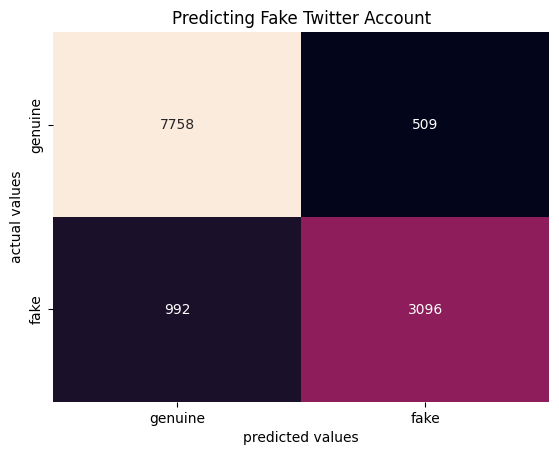

In [30]:
labels = ["genuine", "fake"]
title = "Predicting Fake Twitter Account"
plot_confusion_matrix(y_test, y_pred, labels, title)

# Dump the Model as a Pickle file so it can be used with our API

In [132]:
import pickle
with open('model_pkl', 'wb') as files:
    pickle.dump(pipeline, files)